# Set Up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Get the Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [3]:
df_clean = df[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']]

In [4]:
df_clean.columns = df_clean.columns.str.replace(' ', '_').str.lower()

In [5]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
#Fill in the missing values of the selected features with 0
df_clean = df_clean.fillna(0)

In [7]:
# Rename MSRP variable to price
df_clean.rename(columns={'msrp': 'price'}, inplace=True)

In [8]:
# Let's create a variable above_average which is 1 if the price is above its mean value and 0 otherwise
df_clean['above_average'] = (df_clean['price'] > df_clean['price'].mean()).astype(int)

In [9]:
df_clean.drop('price', axis=1, inplace=True)

In [10]:
#Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']



# Question 1


## Which numerical variable (among the following 4) has the highest AUC?

In [11]:
#Which numerical variable (among the following 4) has the highest AUC?
from sklearn.metrics import roc_auc_score

def auc_score(df, feature):
    score = roc_auc_score(y_train, df[feature])
    return score    

numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for feature in numerical:
    print(feature, auc_score(df_train, feature))






engine_hp 0.9162324220917971
engine_cylinders 0.7674408924408924
highway_mpg 0.3648069378538129
city_mpg 0.3245383956321456


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7624 entries, 0 to 7623
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               7624 non-null   object 
 1   model              7624 non-null   object 
 2   year               7624 non-null   int64  
 3   engine_hp          7624 non-null   float64
 4   engine_cylinders   7624 non-null   float64
 5   transmission_type  7624 non-null   object 
 6   vehicle_style      7624 non-null   object 
 7   highway_mpg        7624 non-null   int64  
 8   city_mpg           7624 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 536.2+ KB


In [13]:
# select categrical features

categorical = ['make', 'model',  'transmission_type', 'vehicle_style']

In [14]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

dv, model = train(df_train, y_train, C=0.001)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


y_pred = predict(df_val, dv, model)



In [15]:
auc = roc_auc_score(y_val, y_pred)
auc

0.9816784918736077

C:\Users\Iñigo\AppData\Local\Temp\ipykernel_6308\1577442677.py:22: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


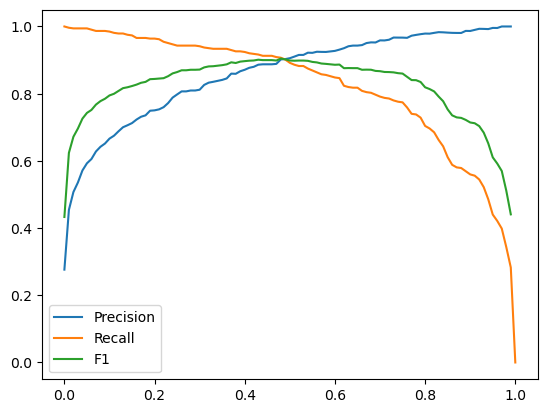

In [16]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01, For each threshold, compute precision and recall, Plot them



scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2 * p * r / (p + r)

    scores.append((t, p, r, f1))

columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()



In [17]:
df_scores

,threshold,precision,recall,f1
0,0.00,0.276350,1.000000,0.433032
1,0.01,0.454152,0.996205,0.623886
2,0.02,0.507260,0.994307,0.671795
3,0.03,0.535787,0.994307,0.696346
4,0.04,0.571429,0.994307,0.725762
...,...,...,...,...
96,0.96,0.995516,0.421252,0.592000
97,0.97,1.000000,0.398482,0.569878
98,0.98,1.000000,0.343454,0.511299
99,0.99,1.000000,0.282732,0.440828


In [18]:
# At which threshold F1 is maximal
df_scores.sort_values(by='f1', ascending=False).head(1)

,threshold,precision,recall,f1
48,0.48,0.901887,0.907021,0.904447


In [25]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [33]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [34]:
np.std(scores)

0.0021961488881011523

In [32]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.9840 +- 0.0022
C=0.01 0.9840 +- 0.0022
C=0.1 0.9840 +- 0.0022
C=0.5 0.9840 +- 0.0022
C=1 0.9840 +- 0.0022
C=5 0.9840 +- 0.0022
C=10 0.9840 +- 0.0022


In [30]:
#obtain standart deviation of the AUC scores across all KFold splits for each value of C
np.std(scores)

0.0021961488881011523

In [29]:
scores.std()

AttributeError: 'list' object has no attribute 'std'